# Тестовое задание
<br>

### Общее описание
В этом задании Вам необходимо реализовать и обучить алгоритм SAC (или любую из его модификаций). Тестирование проводится с помощью одной из классических сред BipedalWalker, которая входит в библиотеку OpenAI Gym.<br><br>

### Критерии оценки

* Тестовое задание считается выполненным, если обученный агент набирает в среднем больше 0 очков. 
* Задание считается решенным очень хорошо, если агент в среднем получает 200+ очков.

In [1]:
# Код для установки пакетов в Google Colab
!pip install Box2D  > /dev/null 2>&1
!pip install gym[all] pyvirtualdisplay > /dev/null 2>&1
!pip install tqdm > /dev/null 2>&1
!apt update > /dev/null 2>&1
!apt install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [1]:
!pip show gym

Name: gym
Version: 0.17.3
Summary: The OpenAI Gym: A toolkit for developing and comparing your reinforcement learning agents.
Home-page: https://github.com/openai/gym
Author: OpenAI
Author-email: gym@openai.com
License: UNKNOWN
Location: /home/kirill/anaconda3/lib/python3.8/site-packages
Requires: cloudpickle, numpy, pyglet, scipy
Required-by: 


In [6]:
import gym
import matplotlib.pyplot as plt
import copy
import random
import numpy as np
from collections import deque
import os

# PyTorch
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from tqdm.notebook import tqdm
from torch.distributions import Normal

# Устройство, на котором будет работать PyTorch.
device = "cuda" if torch.cuda.is_available() else "cpu"  # Model trains faster in GPU

% matplotlib inline

UsageError: Line magic function `%` not found.


In [7]:
#@title Буфер опыта
# Тут ничего менять не нужно

class ExpirienceReplay:
    def __init__(self, size=10000):
        self.data = deque(maxlen=size)

    def add(self, transition):
        self.data.append(transition)

    def sample(self, size):
        batch = random.sample(self.data, size)
        return list(zip(*batch))

In [8]:
#@title Метод build_plot для отрисовки графиков
# Тут ничего менять не нужно

def build_plot(xs, means, stds, labels, figsize=(12, 8)):
    colors = [
        (0.8, 0.0, 0.0),
        (0.0, 0.8, 0.0),
        (0.0, 0.0, 0.8),
        (0.0, 0.5, 0.8)
    ]
    x_min = max([x[0] for x in xs])
    x_max = min([x[-1] for x in xs])
    plt.figure(figsize=figsize)
    plt.plot([x_min, x_max], [150., 150.], color=(0.25, 0.25, 0.25, 0.6), linestyle='-.', label="Minimal solution")
    plt.plot([x_min, x_max], [300., 300.], color=(0.75, 0.75, 0.0, 0.6), linestyle='-.', label="Optimal solution")
    for x, mean, std, label, color in zip(xs, means, stds, labels, colors):
        plt.fill_between(x, mean - 2 * std, mean + 2 * std, color=color, alpha=0.2)
        plt.plot(x, mean, label=label, color=color)
    plt.legend()
    plt.xlim(x_min, x_max)
    plt.ylim(-300, np.max(np.array(means) + 2 * np.array(stds)))
    plt.grid()
    plt.tight_layout()
    plt.show()

In [9]:

# @title Методы train и test
# Тут ничего менять не нужно

def test(sac, seed, episodes=10):
    rewards = []
    env = gym.make("BipedalWalker-v3")
    set_seed(env, seed)
    for _ in range(episodes):
        sum_reward = 0
        done = False
        state = env.reset()
        while not done:
            state, reward, done, _ = env.step(sac.get_action(state, is_evaluating=True))
            sum_reward += reward
        rewards.append(sum_reward)
    return np.mean(rewards), np.std(rewards)


def set_seed(env, seed=0):
    env.seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)


def train(sac, timesteps=50000, batch_size=256, buffer_size=50000,
          start_train=10000, start_steps=5000, test_every=1000, test_count=10, seed=0, update_every=1):
    print(f'Training on: {device}')
    env = gym.make("BipedalWalker-v3")
    set_seed(env, seed)

    done = False
    state = env.reset()
    buffer = ExpirienceReplay(buffer_size)
    actor_loss_sum = 0
    critic_loss_sum = 0
    loss_ctn = 0

    log_ts = []
    log_mean = []
    log_std = []

    best_agent_reward = -np.inf

    rng = tqdm(range(timesteps))
    for t in rng:
        if done:
            done = False
            state = env.reset()

        if t > start_steps:
            action = sac.get_action(state)
        else:
            action = env.action_space.sample()

        next_state, reward, done, _ = env.step(action)
        buffer.add((state, action, next_state, reward, done))
        state = next_state

        if t > start_train:
            if t % update_every == 0:
                for _ in range(update_every):
                    batch = buffer.sample(batch_size)
                    critic_loss, actor_loss = sac.update(batch)
                    actor_loss_sum += actor_loss
                    critic_loss_sum += critic_loss
                    loss_ctn += 1

            if t % test_every == 0 or t == timesteps - 1:
                log_ts.append(t)
                mean, std = test(sac, seed, test_count)
                log_mean.append(mean)
                log_std.append(std)
                tqdm.write(
                    f"Mean reward: {mean:.2f}, Std reward: {std:.2f}, Critic loss: {(critic_loss_sum / loss_ctn):.2f}, "
                    f"Actor loss: {(actor_loss_sum / loss_ctn):.2f}, Alpha: {sac.alpha.detach().cpu().item():.5f}"
                )

                if mean - std > best_agent_reward:
                    best_agent_reward = mean - std
                    sac.save('best_agent_save')

                sac.save('last_agent_save')

                actor_loss_sum = 0
                critic_loss_sum = 0
                loss_ctn = 0
    return np.array(log_ts), np.array(log_mean), np.array(log_std)

### Задание
Вам нужно заполнить пробелы в коде ниже. Код взаимодействия со средой уже реализован за Вас.

In [10]:
LOG_STD_MIN = -20
LOG_STD_MAX = 2


class Actor(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=256, action_limit=1.0):
        super().__init__()

        self.action_limit = action_limit
        self.action_size = action_size

        self.actor = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 2 * action_size)
        )

    def forward(self, state, is_evaluating=False, with_logprob=False):
        """
        Принимает на вход state, который является объектом класса torch.Tensor и имеет размерность (batch_size, state_size)
        Возвращает объект класса torch.Tensor размерности (batch_size, action_size), который является предсказанным действием агента
        """
        mu, log_sigma = torch.split(self.actor(state), self.action_size, -1)

        log_sigma = torch.clamp(log_sigma, LOG_STD_MIN, LOG_STD_MAX)
        policy_distribution = Normal(mu, torch.exp(log_sigma))

        if is_evaluating:
            action = mu
        else:
            # Using reparametrization trick in continuous case as stated in SAC paper
            action = policy_distribution.rsample()

        # Map action of NN to [-1, 1]
        tanh_action = torch.tanh(action)

        if with_logprob:
            # Map log prob for action after applying tanh (SAC paper, appendix C)
            log_prob = policy_distribution.log_prob(action).sum(axis=-1) - torch.log(1 - tanh_action.pow(2) + 1e-6).sum(
                dim=-1)
            return tanh_action * self.action_limit, log_prob

        return tanh_action * self.action_limit


In [11]:
class Critic(nn.Module):
    def __init__(self, state_size, action_size, hidden_size):
        super().__init__()

        self.critic = nn.Sequential(
            nn.Linear(state_size + action_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, state, action):
        """
        Принимает на вход state, который является объектом класса torch.Tensor и имеет размерность (batch_size, state_size)
        Принимает на вход action, который является объектом класса torch.Tensor и имеет размерность (batch_size, action_size)
        Возвращает объект класса torch.Tensor размерности (batch_size, ), который является оценкой Q-function
        """
        state_action = torch.cat([state, action], dim=-1)
        critic_result = self.critic(state_action)
        return critic_result.squeeze(-1)


In [12]:

class SAC:
    def __init__(self, state_size, action_size, hidden_size=256, tau=0.001, gamma=0.99, actor_lr=3e-4, critic_lr=3e-4,
                 entropy_lr=5e-5, init_entropy=None):
        self.gamma = gamma
        self.tau = tau

        self.actor = Actor(state_size, action_size, hidden_size).to(device)
        self.critics = [
            Critic(state_size, action_size, hidden_size).to(device),
            Critic(state_size, action_size, hidden_size).to(device)
        ]
        self.target_critics = [copy.deepcopy(critic) for critic in self.critics]

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizers = [optim.Adam(critic.parameters(), lr=critic_lr) for critic in self.critics]

        for target_critic in self.target_critics:
            for p in target_critic.parameters():
                p.requires_grad = False

        # Using Automating Entropy Adjustment for Maximum Entropy (SAC paper, p.6)
        self.init_alpha = 0.0 if init_entropy is None else np.log(init_entropy)
        # Target entropy is -dim(action_space)
        self.target_entropy = -float(action_size)
        # We optimize log(alpha), instead of alpha
        self.log_alpha = torch.tensor([self.init_alpha], dtype=torch.float32, device=device, requires_grad=True)
        self.alpha_optimizer = optim.Adam([self.log_alpha], lr=entropy_lr)
        self.alpha = self.log_alpha.exp()

    def compute_alpha_loss(self, state):
        with torch.no_grad():
            action, action_log = self.actor(state, with_logprob=True)

        loss = -(self.alpha * (action_log + self.target_entropy)).mean()

        return loss

    def get_action(self, state, is_evaluating=False):
        """
        Принимает на вход state, который является объектом класса numpy.array
        Возвращает action, который является объектом класса numpy.array
        """
        with torch.no_grad():
            state = torch.tensor(state, device=device, dtype=torch.float32)
            action = self.actor(state, is_evaluating=is_evaluating).cpu().numpy()
        return action

    def compute_actor_loss(self, state):
        """
        Принимает на вход state, который является объектом класса torch.Tensor и имеет размерность (batch_size, state_size)
        Возвращает функцию потерь actor'а loss, которая явлеятся объектом класса torch.Tensor
        """
        pi_action, pi_log_prob = self.actor(state, with_logprob=True)
        q_pi = torch.min(
            self.critics[0](state, pi_action),
            self.critics[1](state, pi_action)
        )
        # Calculating -loss func due to gradient descent, in openai doc policy updates with gradient ascent
        loss = (self.alpha.detach() * pi_log_prob - q_pi).mean()
        return loss

    def compute_critic_loss(self, state, action, next_state, reward, done):
        """
        Принимает на вход state, который является объектом класса torch.Tensor и имеет размерность (batch_size, state_size)
        Принимает на вход action, который является объектом класса torch.Tensor и имеет размерность (batch_size, action_size)
        Принимает на вход next_state, который является объектом класса torch.Tensor и имеет размерность (batch_size, state_size)
        Принимает на вход reward, который является объектом класса torch.Tensor и имеет размерность (batch_size, )
        Принимает на вход done, который является объектом класса torch.Tensor и имеет размерность (batch_size, ) и тип bool
        Возвращает функцию потерь critic'а loss, которая явлеятся объектом класса torch.Tensor
        """
        with torch.no_grad():
            pi_next_action, pi_next_log_prob = self.actor(next_state, with_logprob=True)

            q_next = torch.min(
                self.target_critics[0](next_state, pi_next_action),
                self.target_critics[1](next_state, pi_next_action)
            )
            q_target = reward + self.gamma * (1 - done) * (q_next - self.alpha * pi_next_log_prob)

        q_1 = self.critics[0](state, action)
        q_2 = self.critics[1](state, action)

        loss = F.mse_loss(q_1, q_target) + F.mse_loss(q_2, q_target)

        return loss

    def soft_update(self, target_net, source_net):
        """
        Применяет soft update с коэффициентом self.tau обновляя параметры target_net с помощью параметров source_net
        """
        # tau = (1-polyak) parameter. Polyak coefficient is used in spinningup.openai doc
        for p_source, p_target in zip(source_net.parameters(), target_net.parameters()):
            p_target.data.copy_(p_target.data * (1.0 - self.tau) + p_source.data * self.tau)

    def update(self, batch):
        state, action, next_state, reward, done = batch

        state = torch.tensor(state, dtype=torch.float32, device=device)
        action = torch.tensor(action, device=device, dtype=torch.float32)
        next_state = torch.tensor(next_state, dtype=torch.float32, device=device)
        reward = torch.tensor(reward, dtype=torch.float32, device=device)
        done = torch.tensor(done, device=device, dtype=torch.float32)

        # Critics update
        critic_loss = self.compute_critic_loss(state, action, next_state, reward, done)
        [critic.zero_grad() for critic in self.critic_optimizers]
        critic_loss.backward()
        [critic.step() for critic in self.critic_optimizers]

        # Actor update
        actor_loss = self.compute_actor_loss(state)
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Alpha update
        alpha_loss = self.compute_alpha_loss(state)
        self.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.alpha_optimizer.step()
        self.alpha = self.log_alpha.exp()

        # Target critics soft update
        with torch.no_grad():
            [self.soft_update(target_net=target_critic, source_net=critic) for critic, target_critic in
             zip(self.critics, self.target_critics)]

        return critic_loss.item(), actor_loss.item()

    def save(self, name):
        torch.save(self.actor.state_dict(), f'{name}.pkl')

### Запуск обучения агента
Не забудьте потьюнить гиперпараметры для лучшего результата!

In [9]:
xs, means, stds, labels = [], [], [], []
sac = SAC(
    state_size=24,
    action_size=4,
    hidden_size=256,
    tau=0.002,
    gamma=0.99,
    actor_lr=3e-4,
    critic_lr=3e-4,
    entropy_lr=5e-5
)

x, mean, std = train(
    sac=sac,
    timesteps=1_000_000,
    batch_size=256,
    buffer_size=int(1e6),
    start_train=20_000,
    start_steps=55_000,
    test_every=5_000,
    test_count=10,
    update_every=8
)

xs.append(x)
means.append(mean)
stds.append(std)
labels.append(f"SAC")


Training on: cuda


/home/kirill/anaconda3/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


  0%|          | 0/1000000 [00:00<?, ?it/s]

Mean reward: -14.73, Std reward: 0.16, Critic loss: 11.23, Actor loss: -13.95, Alpha: 0.78542
Mean reward: -97.52, Std reward: 0.90, Critic loss: 2.74, Actor loss: -29.96, Alpha: 0.61918
Mean reward: -99.21, Std reward: 2.84, Critic loss: 2.72, Actor loss: -40.65, Alpha: 0.48819
Mean reward: -99.17, Std reward: 1.17, Critic loss: 3.27, Actor loss: -47.22, Alpha: 0.38498
Mean reward: -98.88, Std reward: 1.07, Critic loss: 4.46, Actor loss: -50.47, Alpha: 0.30369
Mean reward: -98.63, Std reward: 0.31, Critic loss: 4.11, Actor loss: -51.62, Alpha: 0.23956
Mean reward: -98.32, Std reward: 0.27, Critic loss: 3.97, Actor loss: -51.49, Alpha: 0.18900
Mean reward: -53.51, Std reward: 28.85, Critic loss: 3.66, Actor loss: -50.28, Alpha: 0.14904
Mean reward: -99.33, Std reward: 33.29, Critic loss: 3.04, Actor loss: -48.09, Alpha: 0.11755
Mean reward: -38.42, Std reward: 1.04, Critic loss: 2.96, Actor loss: -45.36, Alpha: 0.09273
Mean reward: -24.43, Std reward: 6.06, Critic loss: 2.59, Actor los

#### График обучения

531.2632812625849


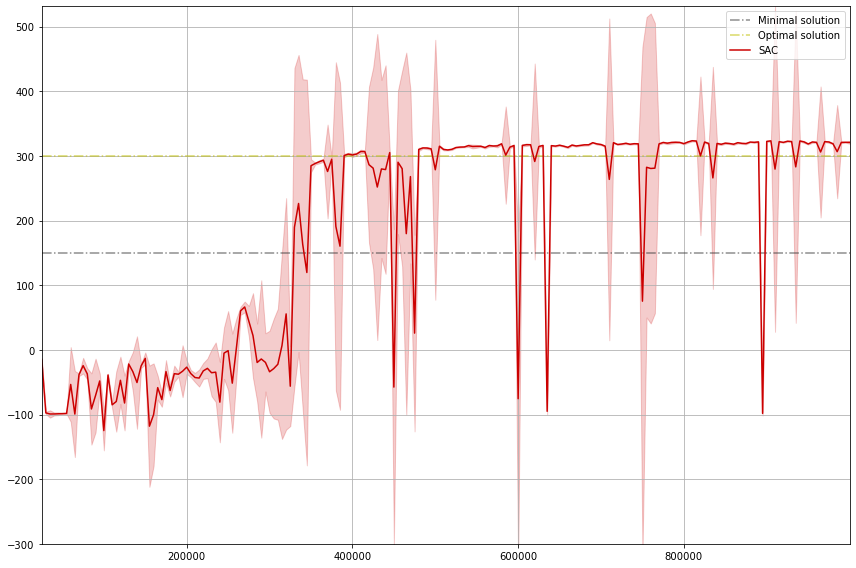

In [36]:
build_plot(xs, means, stds, labels)

#### Тестирование лучшего агента

In [13]:
class Agent:
    def __init__(self, path=None, hidden_size=256, state_size=24, action_size=4):
        self.agent = Actor(state_size=state_size, action_size=action_size, hidden_size=hidden_size)
        self.agent.load_state_dict(torch.load(path, map_location='cpu'))

    def get_action(self, state, is_evaluating=True):
        state = torch.tensor(state, dtype=torch.float32)
        action = self.agent(state, is_evaluating=is_evaluating)
        return action.detach().numpy()

In [14]:
best_agent_path = 'best_agent_save.pkl' if os.path.exists(
    './best_agent_save.pkl') else './jb-rl-sac-solution/best_agent_save.pkl'

agent = Agent(best_agent_path, hidden_size=256, state_size=24, action_size=4)
final_mean, final_std = test(sac=agent, seed=0, episodes=25)
print(f"Agent mean score is {final_mean} with std {final_std}")

/home/kirill/anaconda3/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Agent mean score is 323.59187530579413 with std 0.4651935561394824


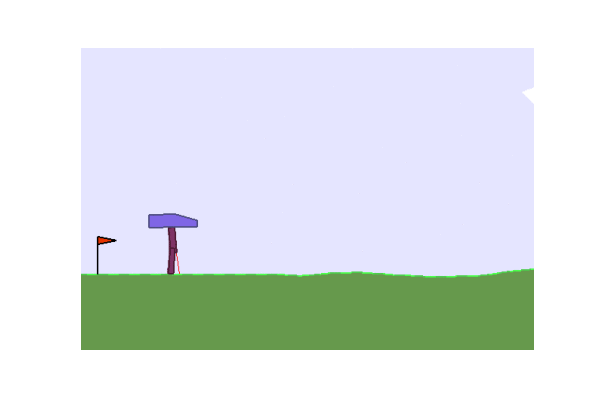

In [21]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
from IPython import display

gifPath = "./best_agent_animation.gif" if os.path.exists(
    "./best_agent_animation.gif") else "./jb-rl-sac-solution/best_agent_animation.gif"

with open(gifPath, 'rb') as f:
    display.Image(data=f.read(), format='png')